In [1]:
import numpy as np
  
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Flatten, Activation, Reshape, Dropout
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import os

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

Using TensorFlow backend.


In [2]:
image_size = 28

def build_generator(image_size):
    input1 = Input(shape=(None, None, 1))
#     input2 = Flatten()(input1)
#     model = Dense(256)(input2)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(512)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(1024)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(image_size*image_size)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Reshape((image_size,image_size,1))(model)
    
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    
    model2 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(model1)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)

    model3 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(model2)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)

    model4 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(model3), model2], axis=3)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    
    model5 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(model4), model1], axis=3)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    
#     model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), model], axis=3)
#     model6 = LeakyReLU(alpha=0.2)(model6)
#     model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), input1], axis=3)
    model6 = LeakyReLU(alpha=0.2)(model6)
    model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(model6)
    
    return Model(inputs=input1, outputs=model6)

def build_discriminator(image_size):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding='same', input_shape=(None, None, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(32, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
#     model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()

    img = Input(shape=(None, None, 1))
    validity = model(img)
    
#     return Model(inputs = input2, outputs = conv)

    return Model(img, validity)

optimizer = Adam(0.001, 0.5)
generator = build_generator(image_size)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
discriminator = build_discriminator(image_size)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(None, None, 1))
img = generator(z)
# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, None, None, 16)    160       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, None, None, 16)    64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_17 (Batc (None, None, None, 16)    64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 32)    4640      
__________

/opt/modules/devel/python/3.5.2/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.059958, acc.: 100.00%] [G loss: 4.240241]


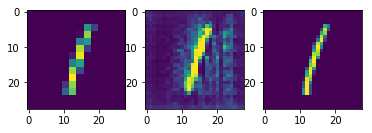

200 [D loss: 0.049408, acc.: 100.00%] [G loss: 3.007589]


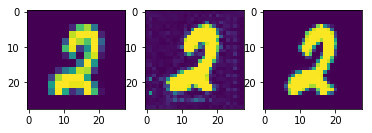

300 [D loss: 0.451849, acc.: 85.50%] [G loss: 1.921739]


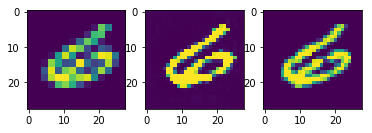

400 [D loss: 0.857275, acc.: 35.00%] [G loss: 1.351187]


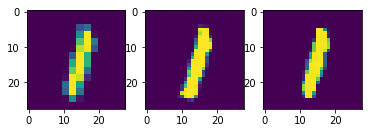

500 [D loss: 0.705732, acc.: 53.00%] [G loss: 0.990811]


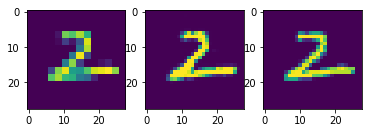

600 [D loss: 0.771604, acc.: 40.00%] [G loss: 0.810125]


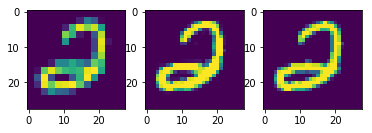

700 [D loss: 0.724903, acc.: 42.50%] [G loss: 0.817992]


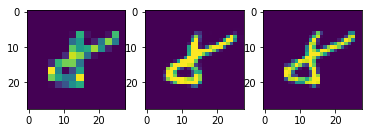

800 [D loss: 0.710915, acc.: 51.00%] [G loss: 0.815805]


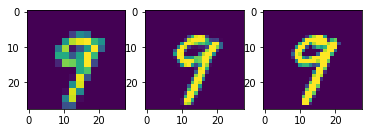

900 [D loss: 0.805823, acc.: 31.50%] [G loss: 0.862244]


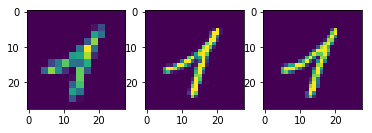

1000 [D loss: 0.713199, acc.: 49.00%] [G loss: 0.825374]


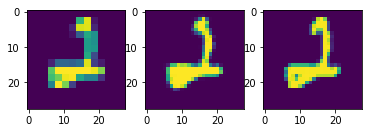

1100 [D loss: 0.681005, acc.: 59.50%] [G loss: 0.919660]


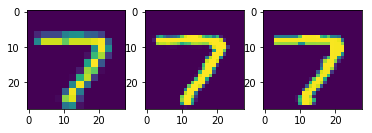

1200 [D loss: 0.706308, acc.: 48.00%] [G loss: 0.803850]


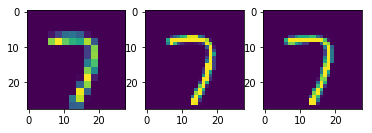

1300 [D loss: 0.776806, acc.: 35.50%] [G loss: 0.885635]


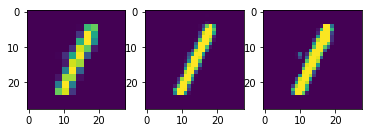

1400 [D loss: 0.766208, acc.: 39.50%] [G loss: 0.875483]


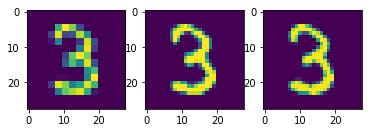

1500 [D loss: 0.713300, acc.: 48.50%] [G loss: 0.862311]


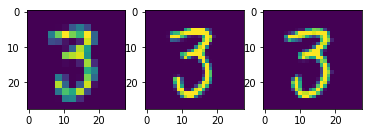

1600 [D loss: 0.767451, acc.: 40.50%] [G loss: 0.878325]


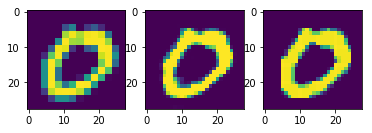

1700 [D loss: 0.684857, acc.: 51.00%] [G loss: 0.883266]


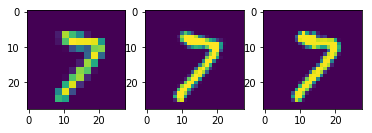

1800 [D loss: 0.689054, acc.: 53.50%] [G loss: 0.876012]


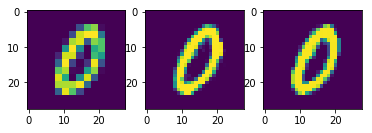

1900 [D loss: 0.746187, acc.: 47.50%] [G loss: 0.842761]


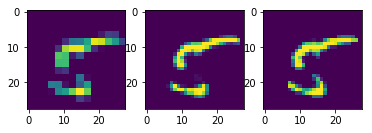

2000 [D loss: 0.689594, acc.: 54.00%] [G loss: 0.818226]


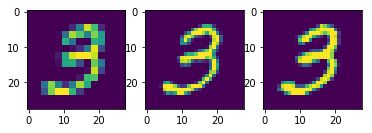

2100 [D loss: 0.837323, acc.: 30.50%] [G loss: 0.800656]


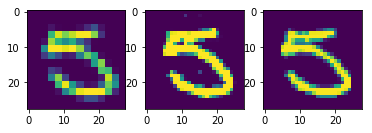

2200 [D loss: 0.748519, acc.: 42.00%] [G loss: 0.860267]


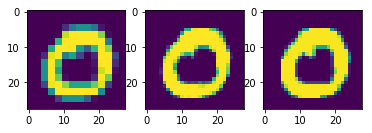

2300 [D loss: 0.680285, acc.: 56.00%] [G loss: 0.869562]


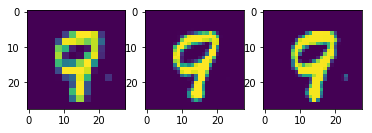

2400 [D loss: 0.720304, acc.: 51.00%] [G loss: 0.897342]


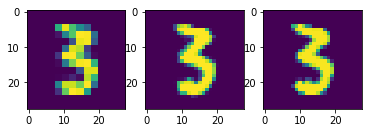

2500 [D loss: 0.720637, acc.: 50.00%] [G loss: 0.844602]


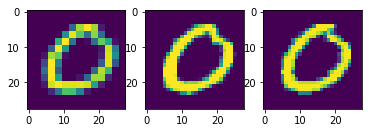

2600 [D loss: 0.767914, acc.: 41.00%] [G loss: 0.771535]


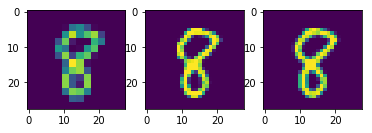

2700 [D loss: 0.781618, acc.: 39.50%] [G loss: 0.944877]


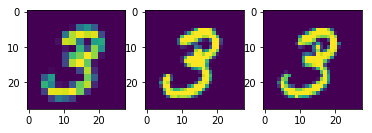

2800 [D loss: 0.680810, acc.: 57.00%] [G loss: 0.709462]


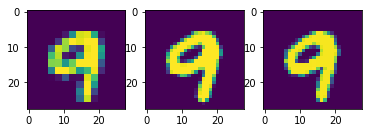

2900 [D loss: 0.565308, acc.: 81.00%] [G loss: 0.989664]


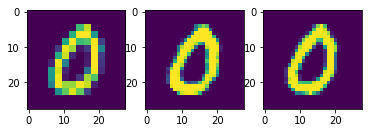

3000 [D loss: 0.742383, acc.: 46.50%] [G loss: 0.838348]


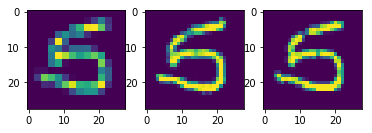

3100 [D loss: 0.540035, acc.: 81.50%] [G loss: 1.084939]


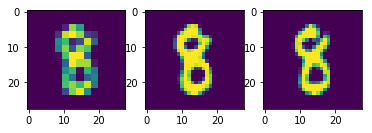

3200 [D loss: 0.372024, acc.: 91.50%] [G loss: 1.140781]


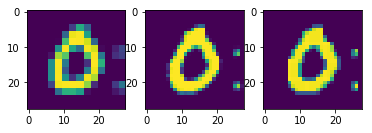

3300 [D loss: 0.661782, acc.: 64.00%] [G loss: 0.983134]


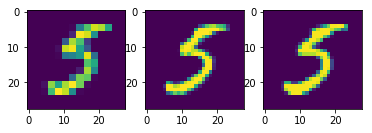

3400 [D loss: 0.941398, acc.: 19.50%] [G loss: 0.885793]


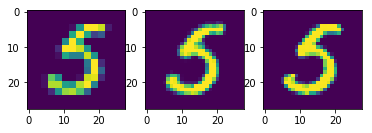

3500 [D loss: 0.841016, acc.: 46.50%] [G loss: 0.956908]


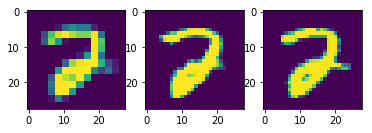

3600 [D loss: 0.570287, acc.: 75.00%] [G loss: 1.359212]


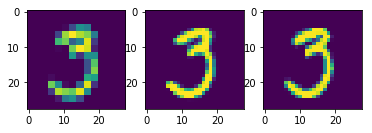

3700 [D loss: 0.403903, acc.: 92.00%] [G loss: 1.656409]


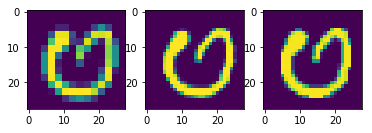

3800 [D loss: 0.499257, acc.: 81.00%] [G loss: 1.062335]


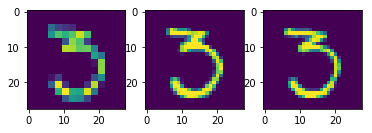

3900 [D loss: 0.206595, acc.: 95.50%] [G loss: 1.615832]


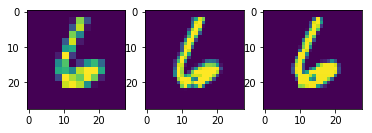

4000 [D loss: 0.375157, acc.: 90.50%] [G loss: 1.464577]


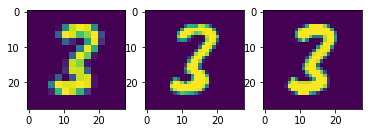

4100 [D loss: 1.032965, acc.: 43.50%] [G loss: 0.711255]


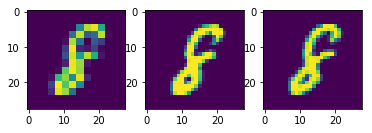

4200 [D loss: 0.710384, acc.: 59.00%] [G loss: 1.497376]


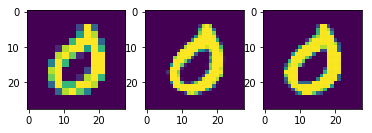

4300 [D loss: 0.464441, acc.: 84.00%] [G loss: 0.858392]


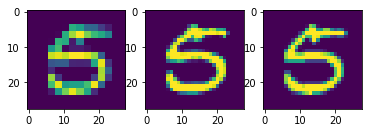

4400 [D loss: 0.874675, acc.: 30.00%] [G loss: 1.358053]


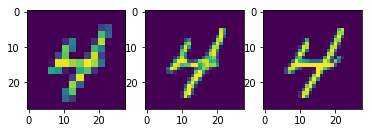

4500 [D loss: 0.443901, acc.: 86.50%] [G loss: 1.770363]


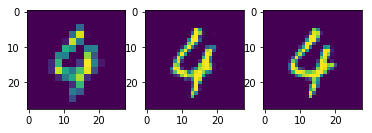

4600 [D loss: 0.301012, acc.: 91.50%] [G loss: 1.374758]


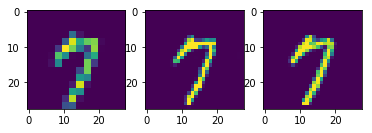

4700 [D loss: 0.436995, acc.: 87.00%] [G loss: 1.077724]


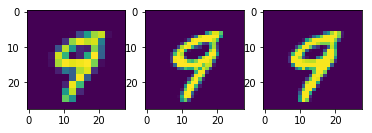

4800 [D loss: 0.271959, acc.: 96.50%] [G loss: 1.761459]


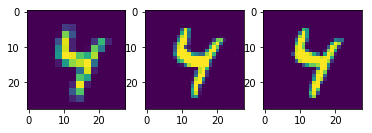

4900 [D loss: 0.441868, acc.: 84.00%] [G loss: 1.266795]


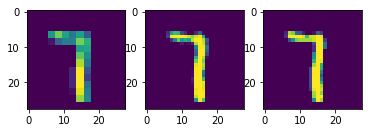

5000 [D loss: 0.893319, acc.: 24.00%] [G loss: 0.973044]


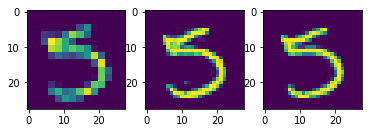

5100 [D loss: 0.808082, acc.: 38.50%] [G loss: 1.027578]


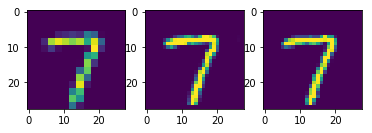

5200 [D loss: 0.628217, acc.: 66.00%] [G loss: 0.626152]


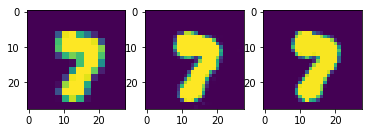

5300 [D loss: 0.633464, acc.: 62.00%] [G loss: 1.050339]


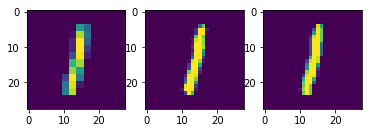

5400 [D loss: 0.422805, acc.: 87.00%] [G loss: 1.589311]


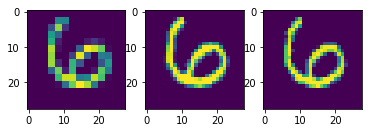

5500 [D loss: 0.549521, acc.: 74.00%] [G loss: 1.667696]


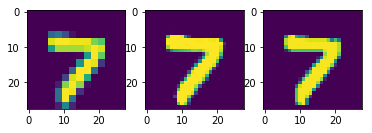

5600 [D loss: 0.572361, acc.: 70.50%] [G loss: 1.564651]


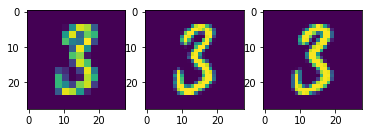

5700 [D loss: 1.257412, acc.: 14.50%] [G loss: 1.829188]


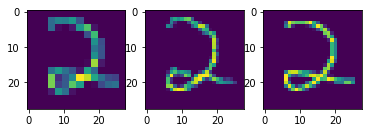

5800 [D loss: 0.367559, acc.: 83.50%] [G loss: 1.587014]


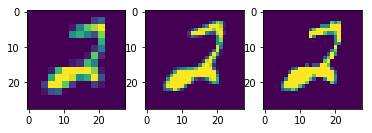

5900 [D loss: 0.863311, acc.: 44.50%] [G loss: 0.996625]


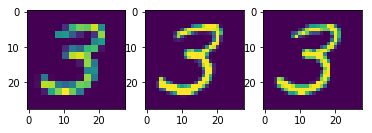

6000 [D loss: 0.142432, acc.: 98.50%] [G loss: 1.266768]


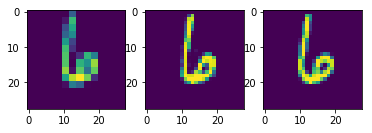

6100 [D loss: 0.578495, acc.: 58.50%] [G loss: 0.720091]


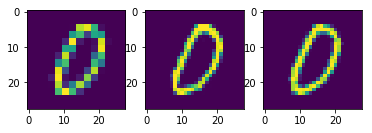

6200 [D loss: 0.526335, acc.: 76.50%] [G loss: 1.141305]


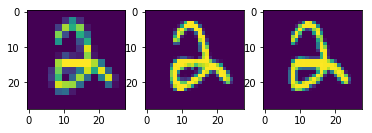

6300 [D loss: 0.805303, acc.: 52.50%] [G loss: 0.973752]


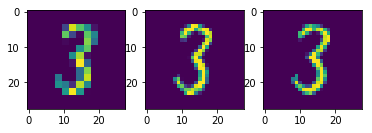

6400 [D loss: 0.384324, acc.: 93.50%] [G loss: 1.690869]


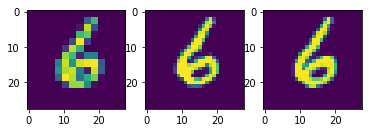

6500 [D loss: 0.486363, acc.: 84.00%] [G loss: 1.418671]


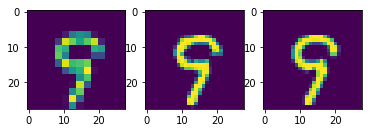

6600 [D loss: 0.677784, acc.: 59.50%] [G loss: 1.507402]


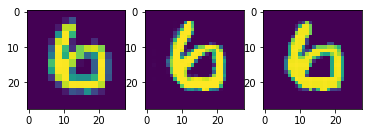

6700 [D loss: 0.690747, acc.: 54.50%] [G loss: 1.322078]


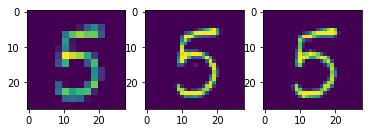

6800 [D loss: 0.421052, acc.: 90.50%] [G loss: 0.977661]


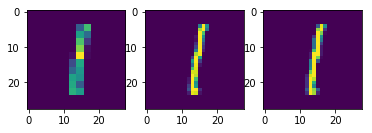

6900 [D loss: 0.711321, acc.: 57.00%] [G loss: 1.439211]


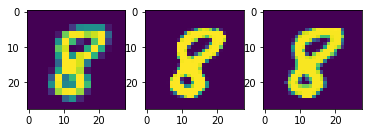

7000 [D loss: 0.363640, acc.: 94.00%] [G loss: 1.983481]


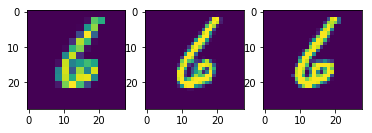

7100 [D loss: 0.174026, acc.: 99.00%] [G loss: 0.260115]


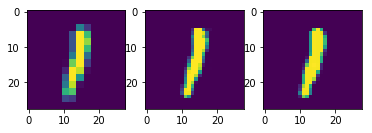

7200 [D loss: 0.905346, acc.: 48.50%] [G loss: 2.293239]


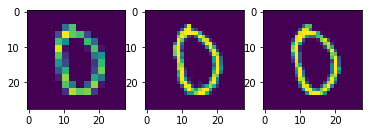

7300 [D loss: 0.179712, acc.: 99.00%] [G loss: 0.593653]


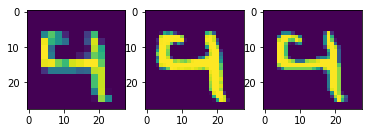

7400 [D loss: 0.483558, acc.: 67.00%] [G loss: 1.423844]


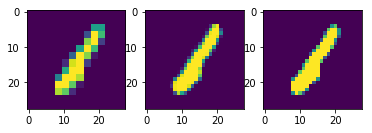

7500 [D loss: 0.502104, acc.: 78.50%] [G loss: 1.201044]


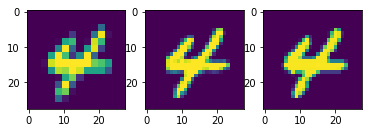

7600 [D loss: 0.161103, acc.: 97.50%] [G loss: 1.251903]


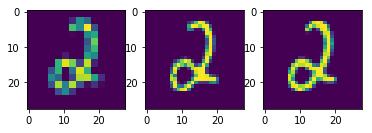

7700 [D loss: 0.353602, acc.: 92.00%] [G loss: 1.581915]


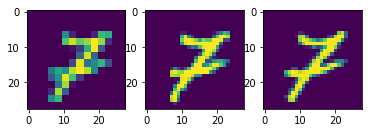

7800 [D loss: 0.172515, acc.: 99.00%] [G loss: 1.721103]


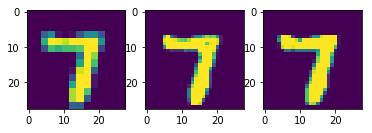

7900 [D loss: 0.275653, acc.: 96.00%] [G loss: 1.903955]


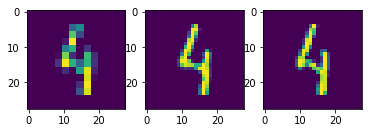

8000 [D loss: 0.538372, acc.: 70.00%] [G loss: 2.360913]


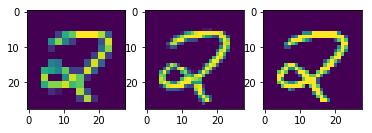

8100 [D loss: 0.292149, acc.: 92.50%] [G loss: 1.319781]


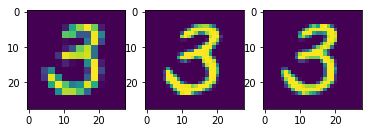

8200 [D loss: 0.553105, acc.: 76.00%] [G loss: 0.481154]


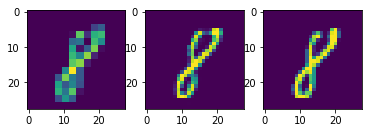

8300 [D loss: 0.924440, acc.: 51.00%] [G loss: 1.981702]


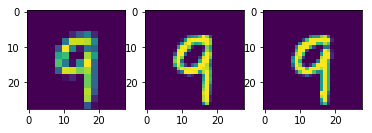

8400 [D loss: 0.506314, acc.: 80.50%] [G loss: 1.902337]


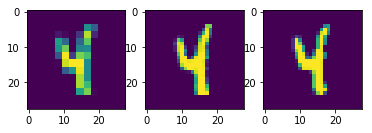

8500 [D loss: 0.939147, acc.: 27.50%] [G loss: 0.522963]


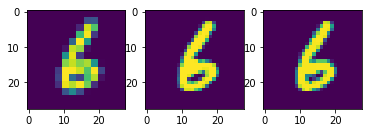

8600 [D loss: 0.346572, acc.: 92.50%] [G loss: 3.044549]


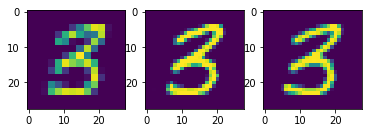

8700 [D loss: 1.240520, acc.: 50.00%] [G loss: 0.955519]


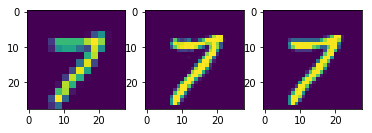

8800 [D loss: 0.361901, acc.: 95.00%] [G loss: 1.835628]


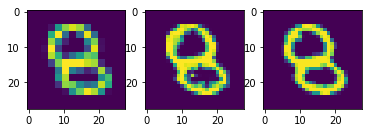

8900 [D loss: 1.097266, acc.: 20.00%] [G loss: 1.211348]


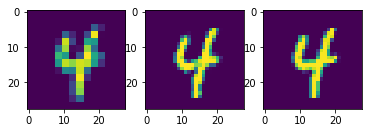

9000 [D loss: 0.749338, acc.: 47.50%] [G loss: 1.169242]


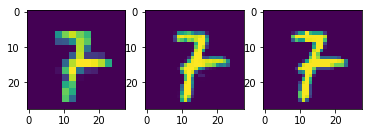

9100 [D loss: 0.439151, acc.: 80.50%] [G loss: 0.692743]


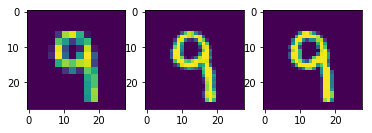

9200 [D loss: 0.634695, acc.: 63.50%] [G loss: 1.612466]


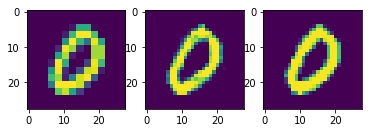

9300 [D loss: 0.144636, acc.: 98.50%] [G loss: 1.475098]


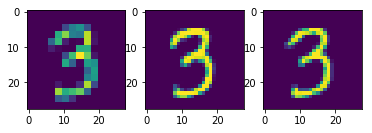

9400 [D loss: 0.732497, acc.: 57.00%] [G loss: 2.110346]


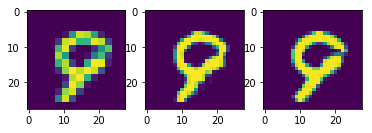

9500 [D loss: 0.472687, acc.: 77.00%] [G loss: 2.069493]


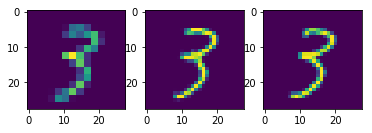

9600 [D loss: 0.309017, acc.: 92.00%] [G loss: 1.991006]


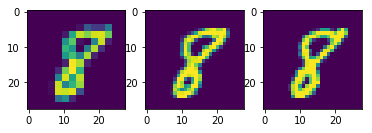

9700 [D loss: 0.656649, acc.: 59.00%] [G loss: 1.349830]


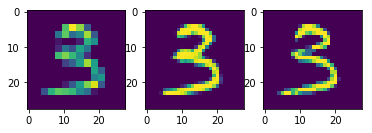

9800 [D loss: 0.792402, acc.: 54.00%] [G loss: 1.122845]


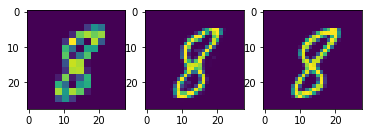

9900 [D loss: 1.880987, acc.: 16.00%] [G loss: 2.146266]


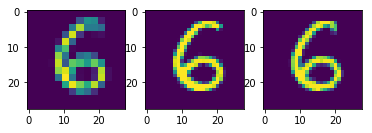

10000 [D loss: 0.144361, acc.: 98.00%] [G loss: 2.129527]


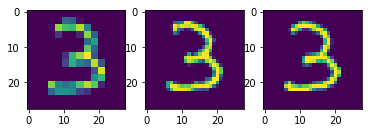

In [3]:
epochs = 10000
batch_size = 200
half_batch = int(batch_size/2)
def reduce_resolution(ims):
    """Preserves image dimensions, but reduces information by averaging cells."""
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).repeat(2, axis = 1).repeat(2, axis = 2).reshape(O, M, N, P)
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)
for epoch in range(1, epochs + 1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)
    # Train the discriminator
    
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx1 = np.random.randint(0, X_train.shape[0], batch_size)
    noise1 = reduce_resolution(X_train[idx1])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise1, [valid_y, X_train[idx1]])
        
    if epoch % 100 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise[0], (28, 28)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [5]:
generator.save('./models/generator_mnist.h5')
discriminator.save('./models/discriminator_mnist.h5')
combined.save('./models/combined_mnist.h5')